<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)


В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
#!pip install datasets

Импорт необходимых библиотек

In [17]:
import torch
import torch.nn as nn
from numpy.ma.extras import unique
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tende\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
[word for word in sent_tokenize(dataset['train']['text'][0], 'english')] # лучше даже использовать данные unsupervised, так как мы в этом нотбуке не используем test данные вообще

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 'I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life.',
 'In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States.',
 'In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic.',
 "Really, the sex and nudity scenes are few an

In [7]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [18]:
import re

sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for review in tqdm(dataset['train']['text']):
    # sentences.extend([re.sub(r'[^\w\s]', '', proposal).lower() for proposal in sent_tokenize(review, 'english') if len(proposal) < word_threshold]) # убираем пунктуацию
    for proposal in sent_tokenize(review, 'english'):
        proposal = word_tokenize(proposal.lower(), 'english')
        if len(proposal) < word_threshold:
            sentences.extend([proposal])

100%|██████████| 25000/25000 [00:24<00:00, 1011.51it/s]


In [19]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


In [20]:
sentences[0]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

Посчитаем для каждого слова его встречаемость.

In [21]:
words = []

# Расчет встречаемости слов
for proposal in sentences:
    words.extend(proposal)

words = Counter(words)
words.most_common(10)

[('.', 170189),
 ('the', 151288),
 (',', 114121),
 ('a', 75273),
 ('and', 73159),
 ('of', 62796),
 ('to', 60494),
 ('is', 57468),
 ('it', 51862),
 ('i', 48989)]

In [22]:
len(words)

68415

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [23]:
vocab = {'<unk>', '<bos>', '<eos>', '<pad>'}
vocab_size = 40000
most_common = [x[0] for x in words.most_common(vocab_size)] # генератор содержащий топ vocab_size слов

# Наполнение множества
vocab = vocab.union(most_common)
print(type(vocab))
list(vocab)[:5]

<class 'set'>


['maneuvered', 'winona', 'human-like', 'hark', 'contribute']

In [24]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [25]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [26]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [27]:
class WordDataset:
    def __init__(self, sentences): # dataset['test']
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        
        # Допишите код здесь
        tokenized_sentence += [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in self.data[idx] # я уже заранее каждое предложение токенизировал, не знаю насколько это правильно с точки зрения общей концепции, но на данных sentences - ок
        ]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [28]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in input_batch]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=pad_id).to(device)
    
    #print("max_seq_len:", padded_sequences.shape[1])

    new_batch = { # [Я, пошёл, в, магазин, .]
        'input_ids': padded_sequences[:,:-1], # [Я, пошёл, в, магазин]
        'target_ids': padded_sequences[:,1:]  # [пошёл, в, магазин, .]
    }

    return new_batch

In [29]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size, drop_last=True) # Добавил drop_last=True

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size, drop_last=True)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size, drop_last=True)

In [30]:
[ind2word[word] for word in eval_dataset[0]]

['<bos>',
 'i',
 'also',
 'thought',
 'that',
 'keene',
 'curtis',
 'was',
 'wonderful',
 'as',
 'eisenhower',
 '.',
 '<eos>']

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [31]:
def evaluate(model, criterion) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [32]:
with torch.no_grad():
    for batch in eval_dataloader:
        pass
        #print(batch['input_ids'].shape, batch['target_ids'].shape)


### Train loop (1 балл)

Напишите функцию для обучения модели.

In [37]:
def train_model(model, criterion, optimizer, dataloader, num_epoch=10):
    losses = []
    perplexities = []
    
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(dataloader, desc=f'Training epoch {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion))
    
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [38]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.3)
        
        self.activation = nn.Tanh()
        
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.activation(self.dropout(self.linear(output)))
        projection = self.projection(output)

        return projection

In [39]:
print(list(ind2word.keys()) == list(range(40004)))

True


In [40]:
# Обучите модель здесь

model = LanguageModel(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

losses, perplexities = train_model(model, criterion, optimizer, train_dataloader)

Training epoch 9:: 100%|██████████| 1242/1242 [01:13<00:00, 16.79it/s]


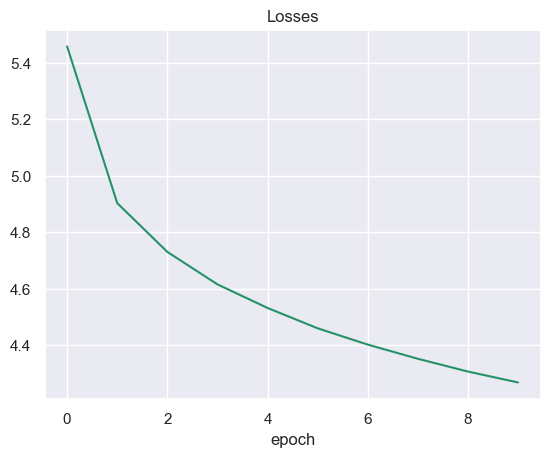

In [41]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

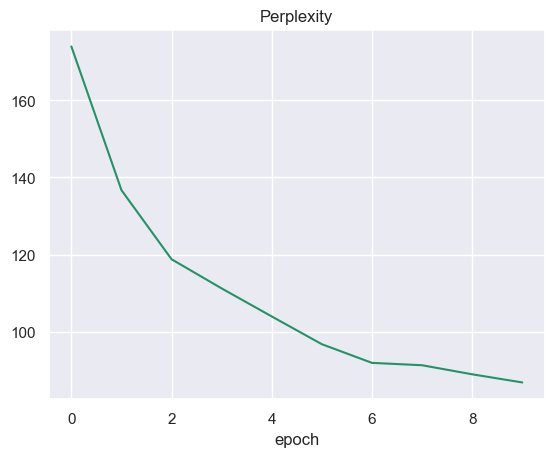

In [42]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [44]:
perplexities[-1]

86.84599985535611

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
# Проведите второй эксперимент

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.